In [102]:
import pandas as pd
from pyspark.sql import SparkSession,functions
from pyspark.sql.functions import when,col,sum
import seaborn as sns

In [6]:
spark = SparkSession.builder.appName("Data Cleansing").getOrCreate()

In [11]:
dt = spark.read.parquet('w2_input.parquet')
dt.show(10)

+--------------+----------+----------+-----+--------+-----------+--------------------+----------------+-------------+------------------+------------------+
|transaction_id|      date|product_id|price|quantity|customer_id|        product_name|customer_country|customer_name|      total_amount|        thb_amount|
+--------------+----------+----------+-----+--------+-----------+--------------------+----------------+-------------+------------------+------------------+
|        581482|2024-05-10|     22485|21.47|      12|    17490.0|Set Of 2 Wooden M...|  United Kingdom| Sara Griffin|            257.64|        11792.1828|
|        581475|2024-05-10|     22596|10.65|      36|    13069.0|Christmas Star Wi...|  United Kingdom| Michael Holt|383.40000000000003|17548.218000000004|
|        581475|2024-05-10|     23235|11.53|      12|    13069.0|Storage Tin Vinta...|  United Kingdom| Michael Holt|138.35999999999999|         6332.7372|
|        581475|2024-05-10|     23272|10.65|      12|    13069.0

Data Cleansing With Pyspark

Check Data type

In [22]:
dt.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- quantity: long (nullable = true)
 |-- customer_id: double (nullable = true)
 |-- product_name: string (nullable = true)
 |-- customer_country: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- thb_amount: double (nullable = true)



In [23]:
dt.select("date").show(10)

+----------+
|      date|
+----------+
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
|2024-05-10|
+----------+
only showing top 10 rows



Change Data type Column "date" : str => datatime

In [28]:
dt_clean = dt.withColumn("date",
                         functions.to_timestamp(dt.date,'yyyy-MM-dd')
                        )
dt_clean.show()
                         

+--------------+-------------------+----------+-----+--------+-----------+--------------------+----------------+-------------+------------------+------------------+
|transaction_id|               date|product_id|price|quantity|customer_id|        product_name|customer_country|customer_name|      total_amount|        thb_amount|
+--------------+-------------------+----------+-----+--------+-----------+--------------------+----------------+-------------+------------------+------------------+
|        581482|2024-05-10 00:00:00|     22485|21.47|      12|    17490.0|Set Of 2 Wooden M...|  United Kingdom| Sara Griffin|            257.64|        11792.1828|
|        581475|2024-05-10 00:00:00|     22596|10.65|      36|    13069.0|Christmas Star Wi...|  United Kingdom| Michael Holt|383.40000000000003|17548.218000000004|
|        581475|2024-05-10 00:00:00|     23235|11.53|      12|    13069.0|Storage Tin Vinta...|  United Kingdom| Michael Holt|138.35999999999999|         6332.7372|
|        5

In [29]:
#Recheck min,max ว่าเปลี่ยนข้อมูลครบไหม
dt_clean.select(functions.min(dt_clean.date),functions.max(dt_clean.date)).show()

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2023-05-03 00:00:00|2024-05-10 00:00:00|
+-------------------+-------------------+



In [30]:
dt_clean.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- quantity: long (nullable = true)
 |-- customer_id: double (nullable = true)
 |-- product_name: string (nullable = true)
 |-- customer_country: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- thb_amount: double (nullable = true)



Anomalies Check

In [33]:
#Syntactical Anomalies
dt_clean.select("customer_country").distinct().count()

39

In [35]:
dt_clean.select("customer_country").distinct().sort("customer_country").show(39)

+--------------------+
|    customer_country|
+--------------------+
|           Australia|
|             Austria|
|             Bahrain|
|             Belgium|
|              Brazil|
|              Canada|
|     Channel Islands|
|              Cyprus|
|      Czech Republic|
|             Denmark|
|                EIRE|
|  European Community|
|             Finland|
|              France|
|             Germany|
|              Greece|
|           Hong Kong|
|             Iceland|
|              Israel|
|               Italy|
|               Japan|
|              Japane|
|             Lebanon|
|           Lithuania|
|               Malta|
|         Netherlands|
|              Norway|
|              Poland|
|            Portugal|
|                 RSA|
|        Saudi Arabia|
|           Singapore|
|               Spain|
|              Sweden|
|         Switzerland|
|                 USA|
|United Arab Emirates|
|      United Kingdom|
|         Unspecified|
+--------------------+



In [40]:
dt_clean.where(dt_clean["customer_country"] == "Japane").show()

+--------------+-------------------+----------+-----+--------+-----------+--------------------+----------------+-------------+------------+-----------+
|transaction_id|               date|product_id|price|quantity|customer_id|        product_name|customer_country|customer_name|total_amount| thb_amount|
+--------------+-------------------+----------+-----+--------+-----------+--------------------+----------------+-------------+------------+-----------+
|        566623|2024-02-14 00:00:00|     21787|11.12|      72|    12756.0|Rain Poncho Retro...|          Japane|    Troy Ball|      800.64|36331.44192|
|        566623|2024-02-14 00:00:00|     21786|10.68|      24|    12756.0|   Polkadot Rain Hat|          Japane|    Troy Ball|      256.32|11631.28896|
|        566623|2024-02-14 00:00:00|     21789|11.12|      24|    12756.0|  Kids Rain Mac Pink|          Japane|    Troy Ball|      266.88|12110.48064|
|        566623|2024-02-14 00:00:00|     21788|11.12|      24|    12756.0|  Kids Rain Ma

In [51]:
dt_clean_country = dt_clean.withColumn("customer_country_update", when(dt_clean["customer_country"] == "Japane", "Japan").otherwise(dt_clean["customer_country"]))
dt_clean_country.select("customer_country_update").distinct().sort("customer_country_update").show(40)

+-----------------------+
|customer_country_update|
+-----------------------+
|              Australia|
|                Austria|
|                Bahrain|
|                Belgium|
|                 Brazil|
|                 Canada|
|        Channel Islands|
|                 Cyprus|
|         Czech Republic|
|                Denmark|
|                   EIRE|
|     European Community|
|                Finland|
|                 France|
|                Germany|
|                 Greece|
|              Hong Kong|
|                Iceland|
|                 Israel|
|                  Italy|
|                  Japan|
|                Lebanon|
|              Lithuania|
|                  Malta|
|            Netherlands|
|                 Norway|
|                 Poland|
|               Portugal|
|                    RSA|
|           Saudi Arabia|
|              Singapore|
|                  Spain|
|                 Sweden|
|            Switzerland|
|                    USA|
|   United A

In [54]:
dt_clean_v2 = dt_clean_country.drop("customer_country").withColumnRenamed("customer_country_update","customer_country")
dt_clean_v2.show()

+--------------+-------------------+----------+-----+--------+-----------+--------------------+-------------+------------------+------------------+----------------+
|transaction_id|               date|product_id|price|quantity|customer_id|        product_name|customer_name|      total_amount|        thb_amount|customer_country|
+--------------+-------------------+----------+-----+--------+-----------+--------------------+-------------+------------------+------------------+----------------+
|        581482|2024-05-10 00:00:00|     22485|21.47|      12|    17490.0|Set Of 2 Wooden M...| Sara Griffin|            257.64|        11792.1828|  United Kingdom|
|        581475|2024-05-10 00:00:00|     22596|10.65|      36|    13069.0|Christmas Star Wi...| Michael Holt|383.40000000000003|17548.218000000004|  United Kingdom|
|        581475|2024-05-10 00:00:00|     23235|11.53|      12|    13069.0|Storage Tin Vinta...| Michael Holt|138.35999999999999|         6332.7372|  United Kingdom|
|        5

In [58]:
#Semantic Anomalies
#Integrity constraints
dt_clean_v2.select("product_id").show(100)

+----------+
|product_id|
+----------+
|     22485|
|     22596|
|     23235|
|     23272|
|     23239|
|     21705|
|     22118|
|     22119|
|     22217|
|     22216|
|     22380|
|     22442|
|     22664|
|     22721|
|     22723|
|     22785|
|     22955|
|     23141|
|     22956|
|     22581|
|     23198|
|     23197|
|     23184|
|     23168|
|     23167|
|     23166|
|     23165|
|     23004|
|     23002|
|     23000|
|     22998|
|     22994|
|     22835|
|     22730|
|     22728|
|     22727|
|     22726|
|     22720|
|     22693|
|     22670|
|     22667|
|     22666|
|     22631|
|     22628|
|     22467|
|     22197|
|     22114|
|     22112|
|     21908|
|     21874|
|     21872|
|     21871|
|     21533|
|     21481|
|     21479|
|     21248|
|     21216|
|     21181|
|     21175|
|     21169|
|     21162|
|     21159|
|     21158|
|     21154|
|     16016|
|     16014|
|     16008|
|     85152|
|    84596F|
|    84596B|
|    84510A|
|     82600|
|     82581|
|     72232|

In [60]:
dt_clean_v2.select("product_id").count()

536350

In [65]:
#แก้ไข Product id ที่ผิดปกติ
#ตรวจสอบจำนวนที่ผิดพลาด 
dt_clean_v2.where(dt_clean_v2["product_id"].rlike("^.{5}$")).count()/dt_clean_v2.count()

0.9050601286473385

In [70]:
#แยกข้อมูลที่ถูกและที่ผิด
dt_correct_product = dt_clean_v2.filter(dt_clean_v2["product_id"].rlike("^{5}$"))
dt_incorrect_product = dt_clean_v2.subtract(dt_correct_product)

In [78]:
#Recheck Product id ที่ผิดปกติสามารถแก้ไขได้ไหม
dt_clean_v2.where(dt_clean_v2["product_id"].startswith("84596")).select("product_id","product_name").show(truncate=False)

+----------+----------------------------------+
|product_id|product_name                      |
+----------+----------------------------------+
|84596F    |Small Marshmallows Pink Bowl      |
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596F    |Small Marshmallows Pink Bowl      |
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596F    |Small Marshmallows Pink Bowl      |
|84596G    |Small Chocolates Pink Bowl        |
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596G    |Small Chocolates Pink Bowl        |
|84596F    |Small Marshmallows Pink Bowl      |
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596F    |Small Marshmallows Pink Bowl      |
|84596F    |Small Marshmallows Pink Bowl      |
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596B    |Small Dolly Mix Design Orange Bowl|
|84596F    |Small Marshmallows Pink Bowl

In [85]:
#แก้ไขโดยตัด Product ID ให้เลือกแค่ 5 ตำแหน่งแรก
dt_clean_v3 = dt_clean_v2.withColumn("product_id",functions.substring("product_id",1,5))
#Recheck
dt_correct_product = dt_clean_v3.filter(dt_clean_v3["product_id"].rlike("^[0-9]{5}$"))
dt_incorrect_product = dt_clean_v3.subtract(dt_correct_product)
dt_incorrect_product.show()

+--------------+----+----------+-----+--------+-----------+------------+-------------+------------+----------+----------------+
|transaction_id|date|product_id|price|quantity|customer_id|product_name|customer_name|total_amount|thb_amount|customer_country|
+--------------+----+----------+-----+--------+-----------+------------+-------------+------------+----------+----------------+
+--------------+----+----------+-----+--------+-----------+------------+-------------+------------+----------+----------------+



Check Missing Value

In [88]:
dt_clean_v3.summary("count").show()

+-------+--------------+----------+------+--------+-----------+------------+-------------+------------+----------+----------------+
|summary|transaction_id|product_id| price|quantity|customer_id|product_name|customer_name|total_amount|thb_amount|customer_country|
+-------+--------------+----------+------+--------+-----------+------------+-------------+------------+----------+----------------+
|  count|        536350|    536350|536350|  536350|     536295|      536350|       536350|      536350|    536350|          536350|
+-------+--------------+----------+------+--------+-----------+------------+-------------+------------+----------+----------------+



In [90]:
dt_clean_v3.where(dt_clean_v3.customer_id.isNull()).show()

+--------------+-------------------+----------+-----+--------+-----------+--------------------+-------------+-------------------+-------------------+----------------+
|transaction_id|               date|product_id|price|quantity|customer_id|        product_name|customer_name|       total_amount|         thb_amount|customer_country|
+--------------+-------------------+----------+-----+--------+-----------+--------------------+-------------+-------------------+-------------------+----------------+
|       C581406|2024-05-09 00:00:00|     46000| 6.19|    -240|       NULL|Polyester Filler ...| Allen Morgan|-1485.6000000000001|         -68397.024|  United Kingdom|
|       C581406|2024-05-09 00:00:00|     46000| 6.19|    -300|       NULL|Polyester Filler ...| Allen Morgan|-1857.0000000000002| -85496.28000000001|  United Kingdom|
|       C575153|2024-04-09 00:00:00|     22947|44.25|      -1|       NULL|Wooden Advent Cal...| Allen Morgan|             -44.25|-2036.4734999999998|  United Kingdom

In [93]:
#Chech normal customer_id
dt_clean_v3.select("customer_id").distinct().show()

+-----------+
|customer_id|
+-----------+
|    17884.0|
|    16561.0|
|    13956.0|
|    14452.0|
|    16596.0|
|    14768.0|
|    13094.0|
|    14285.0|
|    16916.0|
|    17633.0|
|    13607.0|
|    13918.0|
|    14473.0|
|    16629.0|
|    12671.0|
|    14024.0|
|    17267.0|
|    15776.0|
|    12493.0|
|    13533.0|
+-----------+
only showing top 20 rows



In [101]:
#Replace Null ด้วย 00000
dt_clean_v4 = dt_clean_v3.withColumn("customer_id",when(dt_clean_v3["customer_id"].isNull(),00000).otherwise(dt_clean_v3["customer_id"]))
#Recheck
dt_clean_v4.where(dt_clean_v4.customer_id.isNull()).show()

+--------------+----+----------+-----+--------+-----------+------------+-------------+------------+----------+----------------+
|transaction_id|date|product_id|price|quantity|customer_id|product_name|customer_name|total_amount|thb_amount|customer_country|
+--------------+----+----------+-----+--------+-----------+------------+-------------+------------+----------+----------------+
+--------------+----+----------+-----+--------+-----------+------------+-------------+------------+----------+----------------+



Outlier เช็คค่าสูงกว่า หรือต่ำกว่าปกติ 

<Axes: xlabel='price'>

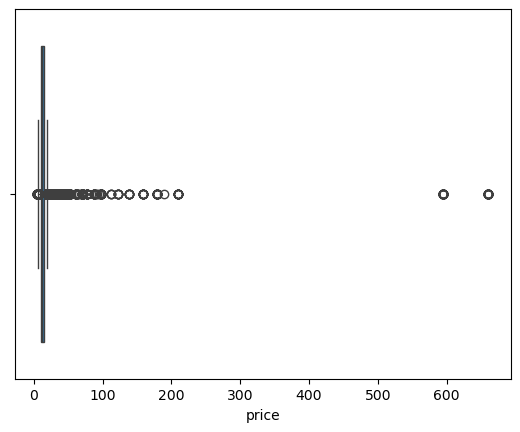

In [103]:
dt_pd = dt_clean_v4.toPandas()
sns.boxplot(x = dt_pd["price"])

In [104]:
dt_clean_v4.where(dt_clean_v4.price > 500).select("product_id","product_name","price").distinct().show()

+----------+--------------------+------+
|product_id|        product_name| price|
+----------+--------------------+------+
|     22656|Vintage Blue Kitc...| 594.5|
|     22656|Vintage Blue Kitc...|660.62|
|     22655|Vintage Red Kitch...|660.62|
|     22655|Vintage Red Kitch...| 594.5|
+----------+--------------------+------+



Recheck เป็นราคาจริง ไม่ต้องแก้ไข

Parquet Export

In [106]:
dt_clean_v4.write.parquet("data_output/clean_data_output.parquet")

In [107]:
dt2 = spark.read.parquet("data_output/clean_data_output.parquet")
dt2.show()

+--------------+-------------------+----------+-----+--------+-----------+--------------------+-------------+------------------+------------------+----------------+
|transaction_id|               date|product_id|price|quantity|customer_id|        product_name|customer_name|      total_amount|        thb_amount|customer_country|
+--------------+-------------------+----------+-----+--------+-----------+--------------------+-------------+------------------+------------------+----------------+
|        581482|2024-05-10 00:00:00|     22485|21.47|      12|    17490.0|Set Of 2 Wooden M...| Sara Griffin|            257.64|        11792.1828|  United Kingdom|
|        581475|2024-05-10 00:00:00|     22596|10.65|      36|    13069.0|Christmas Star Wi...| Michael Holt|383.40000000000003|17548.218000000004|  United Kingdom|
|        581475|2024-05-10 00:00:00|     23235|11.53|      12|    13069.0|Storage Tin Vinta...| Michael Holt|138.35999999999999|         6332.7372|  United Kingdom|
|        5